# Transfer Learning with TensorFlow Part 2: Fine-tuning

In [61]:
!nvidia-smi

Sun Jan  7 12:32:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0              32W /  70W |   4221MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Creating helper functions

In [62]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-01-07 12:32:54--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-07 12:32:54 (109 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [63]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

**! tf.keras.applications !**

In [64]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2024-01-07 12:32:54--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.207, 142.251.12.207, 172.217.194.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  22.2MB/s    in 8.3s    

2024-01-07 12:33:03 (19.3 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [65]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [66]:
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [67]:
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=32)
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [68]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [69]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [70]:
train_data_10_percent.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [71]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[ 69.97194     51.212532    26.333067  ]
   [ 82.98007     58.46365     32.13106   ]
   [ 96.47497     64.31888     35.620056  ]
   ...
   [139.58054     81.580536    33.580532  ]
   [136.92856     78.92856     30.928558  ]
   [136.09328     78.093285    30.09328   ]]

  [[ 85.40625     56.43367     28.789381  ]
   [ 94.678734    61.681126    33.826214  ]
   [ 97.39907     59.43527     29.794641  ]
   ...
   [139.16788     81.16787     33.167873  ]
   [136.20105     78.20105     30.20105   ]
   [137.14066     79.14066     31.14066   ]]

  [[ 94.064415    55.841198    26.535395  ]
   [ 98.97226     58.749043    27.44324   ]
   [ 99.07972     57.105072    24.130419  ]
   ...
   [141.52007     83.520065    35.52007   ]
   [136.28395     78.28396     30.283957  ]
   [136.80171     78.801704    30.801706  ]]

  ...

  [[ 72.337074    60.33707     44.33707   ]
   [ 73.92857     61.928574    45.928574  ]
   [ 77.06553     64.06553     47.065525  ]
   ...
   [135.51819    128.732

## Model 0: Building a transfer learning model using the Keras Functional API

In [72]:
# 1. Create the base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# 2. Freeze the base model
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs dont have to be normalized)
x = base_model(inputs)
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 validation_steps=int(0.25*len(test_data_10_percent)),
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20240107-123309
Epoch 1/5
24/24 [==============================] - 13s 207ms/step - loss: 1.8882 - accuracy: 0.4213 - val_loss: 1.3216 - val_accuracy: 0.7237
Epoch 2/5
24/24 [==============================] - 4s 168ms/step - loss: 1.1434 - accuracy: 0.7467 - val_loss: 0.9071 - val_accuracy: 0.7961
Epoch 3/5
24/24 [==============================] - 4s 169ms/step - loss: 0.8467 - accuracy: 0.8027 - val_loss: 0.7074 - val_accuracy: 0.8438
Epoch 4/5
24/24 [==============================] - 3s 123ms/step - loss: 0.6965 - accuracy: 0.8533 - val_loss: 0.6116 - val_accuracy: 0.8536
Epoch 5/5
24/24 [==============================] - 5s 184ms/step - loss: 0.6075 - accuracy: 0.8560 - val_loss: 0.5811 - val_accuracy: 0.8405


In [73]:
# Evaluate on the full test dataset
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 6s 66ms/step - loss: 0.5758 - accuracy: 0.8512


[0.5757720470428467, 0.8511999845504761]

In [74]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_4
1 rescaling_3
2 normalization_3
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 b

In [75]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, None, None, 3)        0         ['input_4[0][0]']             
                                                                                                  
 normalization_3 (Normaliza  (None, None, None, 3)        0         ['rescaling_3[0][0]']         
 tion)                                                                                            
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [76]:
model_0.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
________________

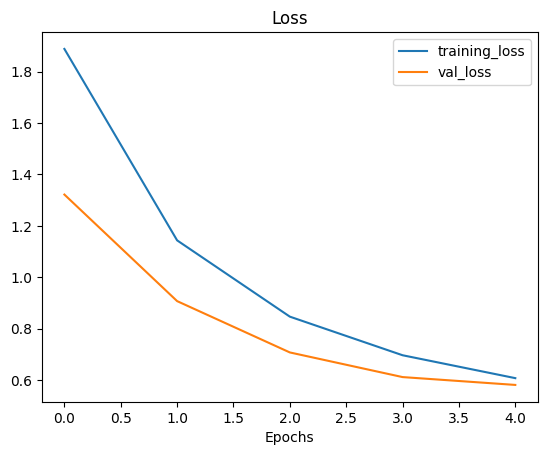

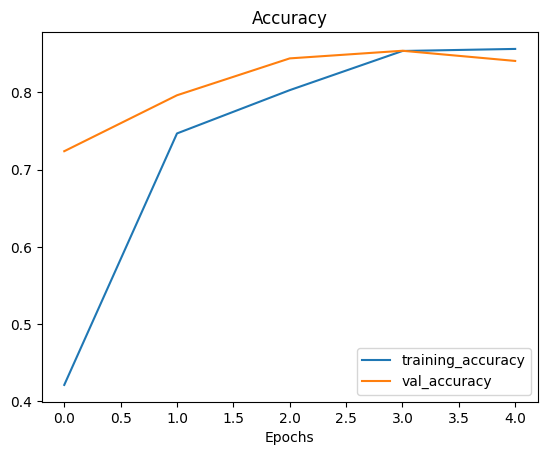

In [77]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

Let's demonstrate the GlobalAveragePooling 2D layer...

We have a tensor after our model goes trough `base_model` of shape (None, 7, 7, 1280).

But then when it passes trough GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1,4,4,3) and then pass it to GlobalAveragePooling2D.

In [78]:
# Define input tensor shape (same number of dimensions as the output of efficientnetv2-b0)
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor trough the GAP 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]
Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average: (1, 3)


In [79]:
# Let's replicate the GAP2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [80]:
# Pass the random tensor trough the GMP 2D layer
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
print(f"2D global max pooled random tensor:\n {global_max_pooled_tensor}")

2D global max pooled random tensor:
 [[0.9058464 1.1603122 1.6994323]]


## Running a series of transfer learning experiments

1. Model 1: Use feature extraction transfer learning on 1% of the training data with data augmentation.
2. Model 2: Use feature extraction transfer learning on 10% of the training data with data augmentation and save the results to a checkpoint.
3. Model 3: Fine-tune the Model 2 checkpoint on 10% of the training data with data augmentation.
4. Model 4: Fine-tune the Model 2 checkpoint on 100% of the training data with data augmentation.

! SAME DATASET !

In [81]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2024-01-07 12:33:52--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.207, 64.233.170.207, 142.251.175.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M  23.0MB/s    in 6.7s    

2024-01-07 12:33:59 (19.1 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [82]:
unzip_data("10_food_classes_1_percent.zip")

In [83]:
# Create training and testing dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir_1_percent = "10_food_classes_1_percent/test"

In [84]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There a

### Getting and preprocessing data for model_1

In [85]:
# Setup data loaders
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)
test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir_1_percent,
                                                                          label_mode="categorical",
                                                                          image_size=IMG_SIZE,
                                                                          batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our model, we can use the layers inside:
* tf.keras.layers.experimental.preprocessing()

It works only during training, not during testing!

In [86]:
print(tf.__version__)

2.15.0


In [87]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
], name ="data_augmentation")

### Visualize our data augmentation layer (and see what happens to our data)

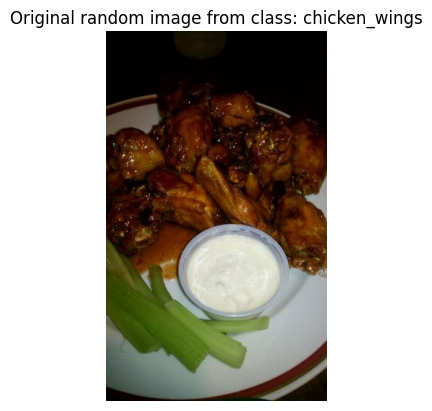

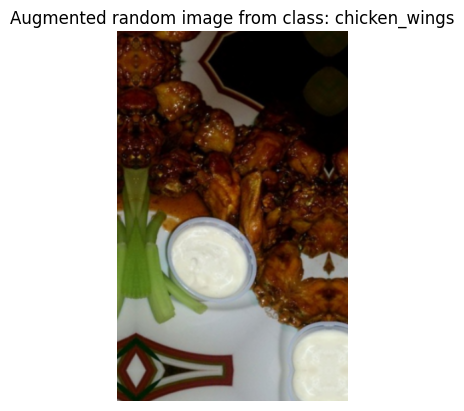

In [88]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);


# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0), training=True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img/255.))
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

In [89]:
train_data_1_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [90]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224,224,3)

In [91]:
IMG_SIZE + (3,)

(224, 224, 3)

In [92]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer")

x = data_augmentation(inputs)

x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data_1_percent,
                                validation_steps=int(0.25*len(test_data_1_percent)),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20240107-123408
Epoch 1/5
3/3 [==============================] - 15s 3s/step - loss: 2.4745 - accuracy: 0.0714 - val_loss: 2.2236 - val_accuracy: 0.1875
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.1383 - accuracy: 0.2143 - val_loss: 2.1071 - val_accuracy: 0.2599
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 2.0350 - accuracy: 0.3143 - val_loss: 2.0104 - val_accuracy: 0.3043
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.8808 - accuracy: 0.5000 - val_loss: 1.9098 - val_accuracy: 0.3865
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.7333 - accuracy: 0.5429 - val_loss: 1.8406 - val_accuracy: 0.4194


In [93]:
model_1.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

In [94]:
results_1_percent_data_aug = model_1.evaluate(test_data_1_percent)
results_1_percent_data_aug

79/79 [==============================] - 7s 78ms/step - loss: 1.8251 - accuracy: 0.4256


[1.825142741203308, 0.42559999227523804]

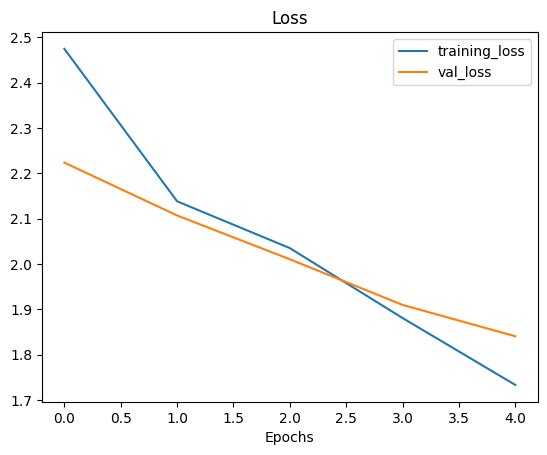

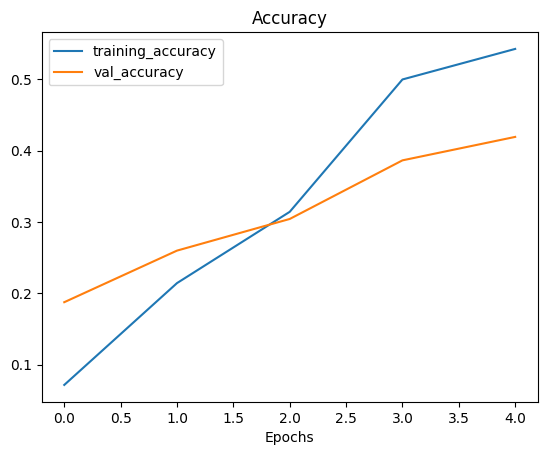

In [95]:
plot_loss_curves(history_1_percent)

## Model 2: feature extraction transfer learning model with 10% of data and data augmentation

In [96]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir_10_percent = "10_food_classes_10_percent/test/"

In [97]:
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir_10_percent,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [98]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [99]:
# MODEL 2
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    layers.RandomRotation(0.2)
    # preprocessing.Rescaling (1/255.) #if using ResNetv2
]
    ,name="data_augmentation")

input_size = (224,224,3)

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False)
base_model.trainable = False

inputs = layers.Input(shape=input_size, name="input_layer")

x = data_augmentation(inputs)

x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D(name="globalaveragepooling2d")(x)

outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [100]:
model_2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 globalaveragepooling2d (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

### Creating model checkpointing callback
**The ModelCheckpoint** callback gives you the ability to save your model, as a whole in the SavedModel format or the weights (patterns) only to a specified directory as it trains.

This is helpful if you think your model is going to be training for a long time and you want to make backups of it as it trains. It also means if you think your model could benefit from being trained for longer, you can reload it from a specific checkpoint and continue training from there.

In [101]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose=1)

## Fit model 2 passing in the ModelCheckpoint callback

In [102]:
initial_epochs = 5

history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data = test_data,
                                          validation_steps = int(0.25*len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                 experiment_name="10_percent_data_aug"),
                                                     checkpoint_callback])


Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20240107-123456
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0155 - accuracy: 0.3667
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 32s 993ms/step - loss: 2.0155 - accuracy: 0.3667 - val_loss: 1.4975 - val_accuracy: 0.6711
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3834 - accuracy: 0.6587
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 16s 665ms/step - loss: 1.3834 - accuracy: 0.6587 - val_loss: 1.0389 - val_accuracy: 0.7747
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.1038 - accuracy: 0.7347
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 20s 777ms/step - loss: 1.1038 - accuracy: 0.7347 - val_loss: 0.8218 - val_accuracy: 0.8158
E

In [103]:
model_0.evaluate(test_data)

79/79 [==============================] - 7s 77ms/step - loss: 0.5758 - accuracy: 0.8512


[0.575772225856781, 0.8511999845504761]

In [104]:
model_2_result = model_2.evaluate(test_data)

79/79 [==============================] - 5s 61ms/step - loss: 0.6430 - accuracy: 0.8388


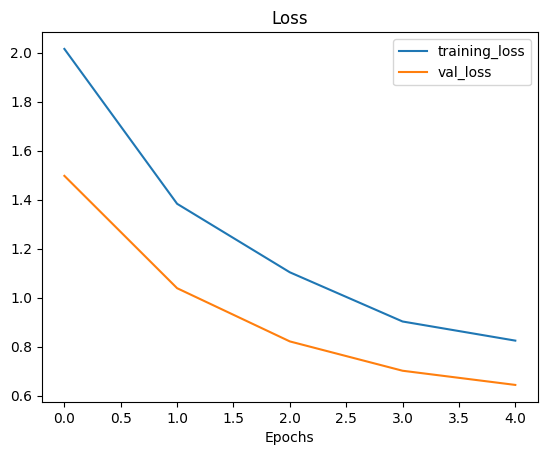

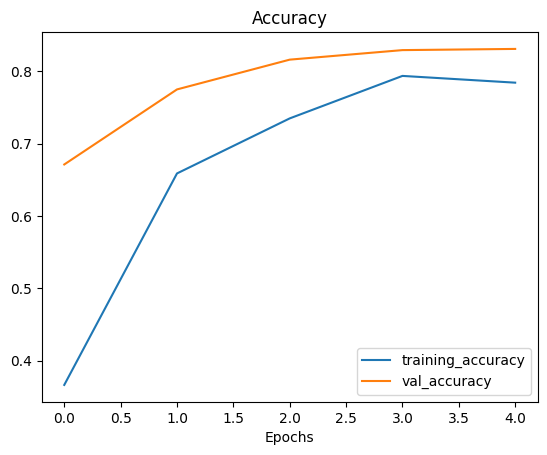

In [105]:
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights
Loading in checkpointed weights returns a model to a specific checkpoint.

In [106]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [107]:
loaded_model_2_result = model_2.evaluate(test_data)

79/79 [==============================] - 5s 60ms/step - loss: 0.6430 - accuracy: 0.8388


In [108]:
model_2_result

[0.6429606676101685, 0.8388000130653381]

In [109]:
loaded_model_2_result

[0.6429604887962341, 0.8388000130653381]

In [110]:
import numpy as np
np.isclose(np.array(model_2_result), np.array(loaded_model_2_result))

array([ True,  True])

In [111]:
print(np.array(model_2_result) - np.array(loaded_model_2_result))

[1.78813934e-07 0.00000000e+00]


## Model 3: Fine-tuning an existing model on 10% of the data

**Note:** Fine-tuning usually works best with previously trained feature extraction model (for a few epochs).

In [112]:
# Layers in model_2
model_2.layers

In [113]:
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7f2b9963d660> True
<keras.src.engine.sequential.Sequential object at 0x7f2b9963c4c0> True
<keras.src.engine.functional.Functional object at 0x7f2b88d93070> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f2b9963d030> True
<keras.src.layers.core.dense.Dense object at 0x7f2b88bc2b90> True


In [114]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_6 False
1 rescaling_5 False
2 normalization_5 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [115]:
# How may trainable variables are in our model?
print(len(model_2.layers[2].trainable_variables))

0


In [116]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

In [117]:
for layer in base_model.layers[-10:]:
  print(layer.name)

block6h_se_reduce
block6h_se_expand
block6h_se_excite
block6h_project_conv
block6h_project_bn
block6h_drop
block6h_add
top_conv
top_bn
top_activation


In [118]:
# Recompile every time we make a change !

In [119]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001), # lowering lr with fine-tuning!; 10 times less
                metrics=["accuracy"])

In [121]:
print(len(model_2.trainable_variables))

12


In [122]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25*len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # Start from previous last epoch
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="10_percent_fine_tune_last_10")]
                                               )

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20240107-124630
Epoch 5/10
24/24 [==============================] - 31s 828ms/step - loss: 0.7064 - accuracy: 0.7973 - val_loss: 0.5023 - val_accuracy: 0.8322
Epoch 6/10
24/24 [==============================] - 18s 737ms/step - loss: 0.5779 - accuracy: 0.8200 - val_loss: 0.4406 - val_accuracy: 0.8372
Epoch 7/10
24/24 [==============================] - 16s 678ms/step - loss: 0.5089 - accuracy: 0.8400 - val_loss: 0.4742 - val_accuracy: 0.8355
Epoch 8/10
24/24 [==============================] - 14s 547ms/step - loss: 0.4971 - accuracy: 0.8373 - val_loss: 0.4629 - val_accuracy: 0.8470
Epoch 9/10
24/24 [==============================] - 15s 619ms/step - loss: 0.4723 - accuracy: 0.8493 - val_loss: 0.4149 - val_accuracy: 0.8569
Epoch 10/10
24/24 [==============================] - 20s 841ms/step - loss: 0.4668 - accuracy: 0.8467 - val_loss: 0.4182 - val_accuracy: 0.8586


In [123]:
# Evaluate the fine-tuned model
results_fine_tune_10_percent = model_2.evaluate(test_data)
results_fine_tune_10_percent

79/79 [==============================] - 6s 70ms/step - loss: 0.4369 - accuracy: 0.8544


[0.4369417428970337, 0.8543999791145325]

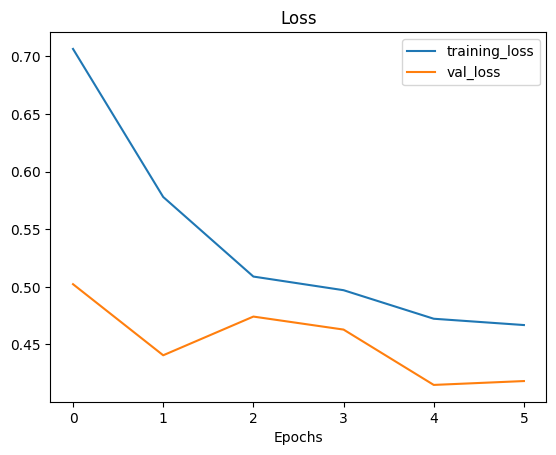

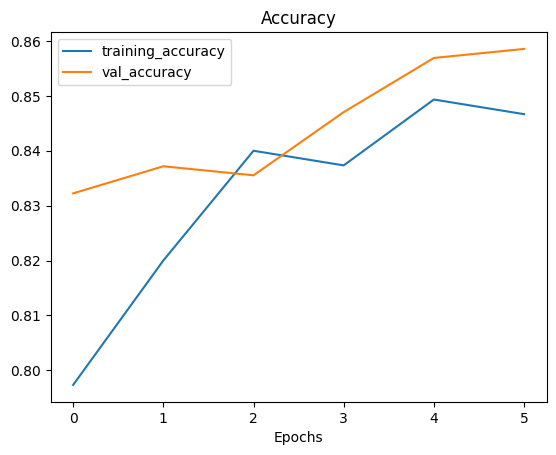

In [124]:
plot_loss_curves(history_fine_10_percent_data_aug)

In [132]:
# Function to compare a function to compare training histories

def compare_historys(original_history, new_history, initial_epochs=5):
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plot for accuracy
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Val Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Make plot for loss
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Val Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

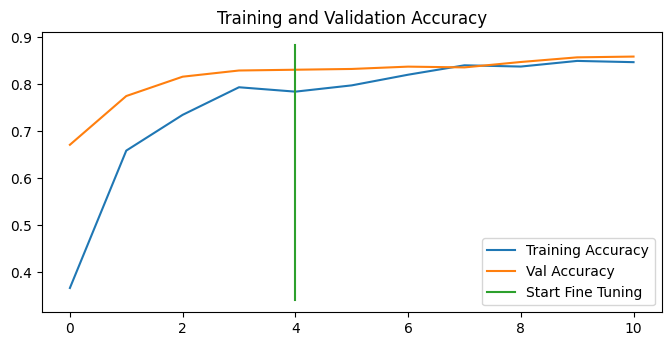

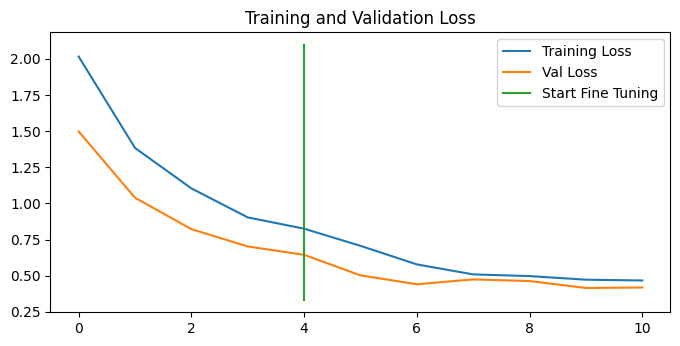

In [133]:
compare_historys(history_10_percent_data_aug,
                 history_fine_10_percent_data_aug,
                 initial_epochs=5)

## Model 4: Fine-tuning an existing model all of the data

In [134]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2024-01-07 13:06:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.175.207, 74.125.24.207, 142.251.10.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.175.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  22.5MB/s    in 24s     

2024-01-07 13:06:41 (20.8 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [135]:
# Setup data directories
train_dir_all_data = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [136]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.

In [137]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [144]:
def create_base_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                      output_shape: int = 10,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:
    """
    Create a model based on EfficientNetV2B0 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
    """

    # Create base model
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    base_model.trainable = training

    # Setup model input and outputs with data augmentation built-in
    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = data_augmentation(inputs)
    x = base_model(x, training=False)  # pass augmented images to base model but keep it in inference mode
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    # Compile model
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    return model

In [141]:
# Evaluate model 2
model_2.evaluate(test_data)

79/79 [==============================] - 9s 96ms/step - loss: 0.4369 - accuracy: 0.8544


[0.43694180250167847, 0.8543999791145325]

In [142]:
results_fine_tune_10_percent

[0.4369417428970337, 0.8543999791145325]

In [163]:
# Load weights from checkpoint
model_5 = create_base_model(learning_rate=0.0001)

In [164]:
model_5.load_weights(checkpoint_path)

In [165]:
model_5.evaluate(test_data)

79/79 [==============================] - 13s 124ms/step - loss: 0.6430 - accuracy: 0.8388


[0.6429604887962341, 0.8388000130653381]

In [166]:
# Check which layers are trainable
for layer_number, layer in enumerate(model_5.layers):
  print(layer_number, layer, layer.trainable)

0 <keras.src.engine.input_layer.InputLayer object at 0x7f2af75aefb0> True
1 <keras.src.engine.sequential.Sequential object at 0x7f2b9963c4c0> True
2 <keras.src.engine.functional.Functional object at 0x7f2af75d6800> False
3 <keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f2af7c662f0> True
4 <keras.src.layers.core.dense.Dense object at 0x7f2af7568370> True


In [167]:
for layer_number, layer in enumerate(model_5.layers[2].layers):
  print(layer_number, layer, layer.trainable)

0 <keras.src.engine.input_layer.InputLayer object at 0x7f2af79979d0> False
1 <keras.src.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f2af7ade8f0> False
2 <keras.src.layers.preprocessing.normalization.Normalization object at 0x7f2af7ee4af0> False
3 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f2af7938610> False
4 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7f2af79dbee0> False
5 <keras.src.layers.core.activation.Activation object at 0x7f2af79dbeb0> False
6 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f2af7806ec0> False
7 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7f2af79d8f10> False
8 <keras.src.layers.core.activation.Activation object at 0x7f2af7996bf0> False
9 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f2af79dbe50> False
10 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7f2af7806440> False
11 <keras.src.layers.

In [168]:
for layer_number, layer in enumerate(model_5.layers[2].layers[-10:]):
  layer.trainable=True
  print(layer_number, layer, layer.trainable)

0 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f2af75437c0> True
1 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f2af76f6110> True
2 <keras.src.layers.merging.multiply.Multiply object at 0x7f2af75ae530> True
3 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f2af756a500> True
4 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7f2af75af700> True
5 <keras.src.layers.regularization.dropout.Dropout object at 0x7f2af75adba0> True
6 <keras.src.layers.merging.add.Add object at 0x7f2af758ea40> True
7 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f2af7929930> True
8 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7f2af7994940> True
9 <keras.src.layers.core.activation.Activation object at 0x7f2af7568670> True


In [169]:
for layer_number, layer in enumerate(model_5.layers[2].layers):
  print(layer_number, layer, layer.trainable)

0 <keras.src.engine.input_layer.InputLayer object at 0x7f2af79979d0> False
1 <keras.src.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f2af7ade8f0> False
2 <keras.src.layers.preprocessing.normalization.Normalization object at 0x7f2af7ee4af0> False
3 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f2af7938610> False
4 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7f2af79dbee0> False
5 <keras.src.layers.core.activation.Activation object at 0x7f2af79dbeb0> False
6 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f2af7806ec0> False
7 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7f2af79d8f10> False
8 <keras.src.layers.core.activation.Activation object at 0x7f2af7996bf0> False
9 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f2af79dbe50> False
10 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7f2af7806440> False
11 <keras.src.layers.

In [170]:
model_5.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [ ]:
fine_tune_epochs = initial_epochs + 10

history_model_5 = model_5.fit(train_data_10_classes_full,
                              epochs=fine_tune_epochs,
                              validation_data=test_data,
                              validation_steps=int(0.25*len(test_data)),
                              initial_epoch=history_10_percent_data_aug.epoch[-1],
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="full_10_classes_fine_tune_last")]
                              )

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last/20240107-135806
Epoch 5/15
235/235 [==============================] - 71s 256ms/step - loss: 0.8717 - accuracy: 0.7501 - val_loss: 0.5770 - val_accuracy: 0.8569
Epoch 6/15
235/235 [==============================] - 50s 211ms/step - loss: 0.8133 - accuracy: 0.7647 - val_loss: 0.5046 - val_accuracy: 0.8684
Epoch 7/15
235/235 [==============================] - 53s 224ms/step - loss: 0.7640 - accuracy: 0.7804 - val_loss: 0.4586 - val_accuracy: 0.8717
Epoch 8/15
235/235 [==============================] - 51s 214ms/step - loss: 0.7324 - accuracy: 0.7832 - val_loss: 0.4657 - val_accuracy: 0.8651
Epoch 9/15
235/235 [==============================] - 43s 181ms/step - loss: 0.7150 - accuracy: 0.7880 - val_loss: 0.4330 - val_accuracy: 0.8766
Epoch 10/15
 26/235 [==>...........................] - ETA: 39s - loss: 0.7380 - accuracy: 0.7825

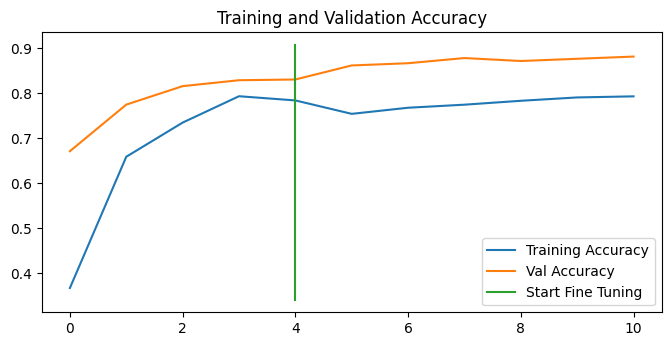

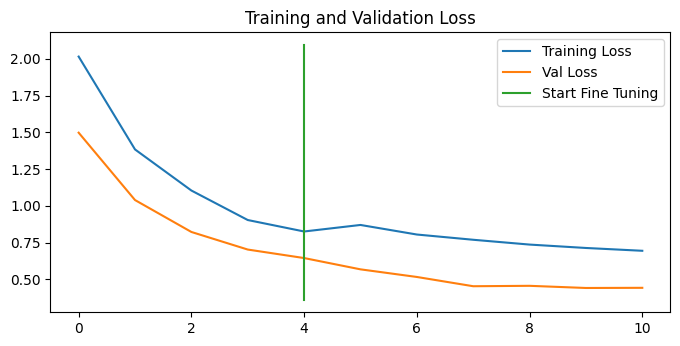

In [159]:
compare_historys(history_10_percent_data_aug,
                 history_model_5,
                 initial_epochs=5)

## Viewing our experiment data on TensorBoard

In [160]:
# View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./transfer_learning \
#   --name "Transfer learning experiments" \
#   --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
#   --one_shot # exits the uploader when upload has finished

In [161]:
# View previous experiments
# !tensorboard dev list


In [162]:
# Remove previous experiments
# !tensorboard dev delete --experiment_id OUbW0O3pRqqQgAphVBxi8Q